In [1]:
import joblib
import numpy as np
import os
import tensorflow as tf
import math
import csv

from keras.models import Model
from keras.layers import Input, merge, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, CSVLogger
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import plot_model
from keras import backend as K
from PIL import Image
from skimage.measure import compare_ssim as ssim
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt # to plot images
%matplotlib inline

Using TensorFlow backend.


### Consts

In [2]:
train_and_val_dataset_file = 'datasets/dataset-1/train-and-val.pkl'
test_dataset_file = 'datasets/dataset-1/test.pkl'
augmented_train_dataset_save_file = 'datasets/dataset-1/train-augmented-{}.pkl'
saved_model_filename = "datasets/dataset-1/test-4-new-tentative-{epoch:02d}-{val_dice_coef_accur:.4f}.hdf5"
csv_logger_training = "datasets/dataset-1/test-4-new-tentative.csv"
result_imgs_folder = 'results/test-6/{}_{}.tiff'

### Load datasets

In [3]:
X_remaining, Y_remaining, remaining_dataset_desc = joblib.load(train_and_val_dataset_file)
Xte, yte, test_dataset_desc = joblib.load(test_dataset_file) # X and y for test
training_set_index = remaining_dataset_desc['training_set_index']
validation_set_index = remaining_dataset_desc['validation_set_index']

Xtr, ytr = X_remaining[:training_set_index,:], Y_remaining[:training_set_index] # X and y for training
Xva, yva = X_remaining[training_set_index:validation_set_index,:], Y_remaining[training_set_index:validation_set_index] # X and y for validation

print(Xtr.shape)
print(Xva.shape)
print(Xte.shape)
print(ytr.shape)
print(yva.shape)
print(yte.shape)

(1402, 128, 128, 1)
(200, 128, 128, 1)
(401, 128, 128, 1)
(1402, 128, 128, 1)
(200, 128, 128, 1)
(401, 128, 128, 1)


### Data augmentation

In [4]:
"""txtyrange = range(-1, 1, 1) # translation range for x and y directions
loat = [ (tx, ty) for tx in txtyrange for ty in txtyrange ] # list of accepted translations
loaa = list(range(-1, 1, 1))
foia = len(loat) * len(loaa) # factor of image augmentation
print(foia)

total_imgs = Xtr.shape[0]
increment = 0

print(total_imgs*foia)

for i in range(total_imgs):
    x = Xtr[i]
    y = ytr[i]
    for (tx, ty) in loat:
        input_array = x.reshape(x.shape[0], x.shape[1])
        output_array = y.reshape(y.shape[0], y.shape[1])
        
        input_image = Image.fromarray(input_array)
        input_image = input_image.transform(input_image.size, Image.AFFINE, (1, 0, tx, 0, 1, ty)) # translated full image

        output_image = Image.fromarray(output_array)
        output_image = output_image.transform(output_image.size, Image.AFFINE, (1, 0, tx, 0, 1, ty)) # translated full image

        for a in loaa:
            increment += 1
            
            if increment % 1000 == 0:
                print("Processed {}/{}".format(increment, total_imgs*foia))
            
            input_image = input_image.rotate(a, resample=Image.BICUBIC) # rotated trcimg
            input_array_augmented = np.array(input_image) # array with pixel values
            Xtr = np.append(Xtr, input_array_augmented).reshape(total_imgs+increment, x.shape[0], x.shape[1], x.shape[2])
            
            output_image = output_image.rotate(a, resample=Image.BICUBIC) # rotated trcimg
            output_array_augmented = np.array(output_image) # array with pixel values
            ytr = np.append(ytr, output_array_augmented).reshape(total_imgs+increment, y.shape[0], y.shape[1], y.shape[2])"""

#joblib.dump((Xtr, ytr), augmented_train_dataset_save_file.format(total_imgs*foia))
Xtr, ytr = joblib.load("datasets/dataset-1/train-augmented-11216.pkl")

### Pre processing

In [5]:
# Preprocessing in the training set (mean and sd) and apply it to all sets

full_image_mean_value = Xtr.mean() # mean-value for each pixel of all full images
full_image_sd = Xtr.std() # standard deviation for each pixel of all full images

Xtr = (Xtr - full_image_mean_value) / full_image_sd
Xva = (Xva - full_image_mean_value) / full_image_sd
Xte = (Xte - full_image_mean_value) / full_image_sd

### Pre-configurations

In [65]:
K.set_image_data_format('channels_last')  # TF dimension
_, *input_image_shape, _ = Xtr.shape
input_image_shape = tuple(input_image_shape)
print(input_image_shape)

smooth = 1.

use_dropout = True
use_regularizers = True
dropout_rate = 0.5
number_of_epochs = 1000
batch_size = 32
kernel_size = (5, 5)
initial_volume_size = 64

(128, 128)


### Define Unet model

In [66]:
# Define loss function
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = 2 * K.sum(y_true_f * y_pred_f) + smooth
    union = K.sum(y_true_f) + K.sum(y_pred_f) + smooth
    return K.mean(intersection / union)

def dice_coef_per_image_in_batch(y_true, y_pred):
    y_true_f = K.batch_flatten(y_true)
    y_pred_f = K.batch_flatten(y_pred)
    intersection = 2. * K.sum(y_true_f * y_pred_f, axis=1, keepdims=True) + smooth
    union = K.sum(y_true_f, axis=1, keepdims=True) + K.sum(y_pred_f, axis=1, keepdims=True) + smooth
    return K.mean(intersection / union)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef_per_image_in_batch(y_true, y_pred)

def dice_coef_accur(y_true, y_pred):
    return dice_coef_per_image_in_batch(y_true, y_pred)
    #y_true_f = K.flatten(y_true)
    #y_pred_f = K.flatten(y_pred)
    #y_pred_f = K.cast(  K.greater_equal(y_pred_f, 0.5)  , tf.float32)
    #accuracy = tf.equal(y_true_f, y_pred_f)
    #return accuracy
    
def IOU_calc(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    
    return 2*(intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def IOU_calc_loss(y_true, y_pred):
    return -IOU_calc(y_true, y_pred)

def setup_regularizers(conv_layer):
    return BatchNormalization()(conv_layer) if use_regularizers else conv_layer
    
def setup_dropout(conv_layer):
    return Dropout(dropout_rate)(conv_layer) if use_dropout else conv_layer

# Define model
inputs = Input((*input_image_shape, 1))
conv1 = Conv2D(initial_volume_size, kernel_size, activation='relu', padding='same')(inputs)
conv1 = Conv2D(initial_volume_size, kernel_size, activation='relu', padding='same')(conv1)
conv1 = setup_regularizers(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = Conv2D(initial_volume_size*2, kernel_size, activation='relu', padding='same')(pool1)
conv2 = Conv2D(initial_volume_size*2, kernel_size, activation='relu', padding='same')(conv2)
conv2 = setup_regularizers(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

conv3 = Conv2D(initial_volume_size*4, kernel_size, activation='relu', padding='same')(pool2)
conv3 = Conv2D(initial_volume_size*4, kernel_size, activation='relu', padding='same')(conv3)
conv3 = setup_regularizers(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

conv4 = Conv2D(initial_volume_size*8, kernel_size, activation='relu', padding='same')(pool3)
conv4 = Conv2D(initial_volume_size*8, kernel_size, activation='relu', padding='same')(conv4)
conv4 = setup_regularizers(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

conv5 = Conv2D(initial_volume_size*16, kernel_size, activation='relu', padding='same')(pool4)
conv5 = Conv2D(initial_volume_size*16, kernel_size, activation='relu', padding='same')(conv5)
conv5 = setup_regularizers(conv5)

up6 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv4], axis=3)
up6 = setup_dropout(up6)
conv6 = Conv2D(initial_volume_size*8, kernel_size, activation='relu', padding='same')(up6)
conv6 = Conv2D(initial_volume_size*8, kernel_size, activation='relu', padding='same')(conv6)

up7 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv3], axis=3)
up7 = setup_dropout(up7)
conv7 = Conv2D(initial_volume_size*4, kernel_size, activation='relu', padding='same')(up7)
conv7 = Conv2D(initial_volume_size*4, kernel_size, activation='relu', padding='same')(conv7)

up8 = concatenate([UpSampling2D(size=(2, 2))(conv7), conv2], axis=3)
up8 = setup_dropout(up8)
conv8 = Conv2D(initial_volume_size*2, kernel_size, activation='relu', padding='same')(up8)
conv8 = Conv2D(initial_volume_size*2, kernel_size, activation='relu', padding='same')(conv8)

up9 = concatenate([UpSampling2D(size=(2, 2))(conv8), conv1], axis=3)
up9 = setup_dropout(up9)
conv9 = Conv2D(initial_volume_size, kernel_size, activation='relu', padding='same')(up9)
conv9 = Conv2D(initial_volume_size, kernel_size, activation='relu', padding='same')(conv9)

conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

model = Model(inputs=[inputs], outputs=[conv10])

model.compile(optimizer=Adam(lr=1e-5), loss=dice_coef_loss, metrics=[dice_coef_accur])
#model.load_weights("datasets/dataset-1/test-5-primeira-rodada-800-0.9538.hdf5")
# Options for the model
print("Size of the CNN: %s" % model.count_params())
#model.load_weights("datasets/dataset-1/test-6-144-0.9554.hdf5")
#plot_model(model, to_file='model.png')
model.load_weights("datasets/dataset-1/test-6-new-tentative-105-0.9527.hdf5")
#model.load_weights("datasets/dataset-1/test-5-new-tentative-682-0.9783.hdf5")

Size of the CNN: 87157889


In [67]:
print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_25 (InputLayer)           (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv2d_457 (Conv2D)             (None, 128, 128, 64) 1664        input_25[0][0]                   
__________________________________________________________________________________________________
conv2d_458 (Conv2D)             (None, 128, 128, 64) 102464      conv2d_457[0][0]                 
__________________________________________________________________________________________________
batch_normalization_36 (BatchNo (None, 128, 128, 64) 256         conv2d_458[0][0]                 
__________________________________________________________________________________________________
max_poolin

### Train model

In [9]:
# Define callbacks
model_checkpoint = ModelCheckpoint(saved_model_filename, monitor='val_dice_coef_accur', save_best_only=True, verbose=1)
csv_logger = CSVLogger(csv_logger_training, append=True, separator=';')

# Train
history = model.fit(Xtr, ytr, batch_size=batch_size, epochs=number_of_epochs, verbose=2, shuffle=True,
             callbacks=[model_checkpoint, csv_logger], validation_data=(Xva, yva))

Train on 12618 samples, validate on 200 samples
Epoch 1/1000


KeyboardInterrupt: 

### Show model metrics

In [9]:
x = history.history['dice_coef_accur']
y = history.history['val_dice_coef_accur']
plt.plot(x, label='train')
plt.plot(y, label = 'val')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

x = history.history['loss']
y = history.history['val_loss']
plt.plot(x, label='train')
plt.plot(y, label='val')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

NameError: name 'history' is not defined

### Show model metrics reading from CSV

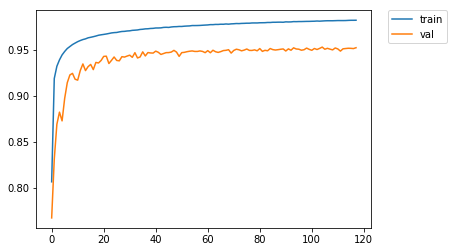

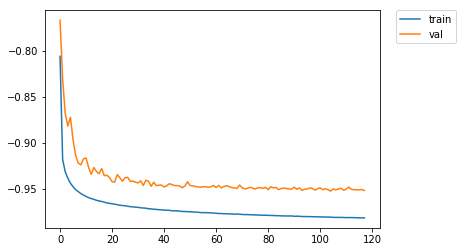

In [9]:
csv_history_file = "datasets/dataset-1/test-6-new-tentative.csv"
data = {}

with open(csv_history_file, "r") as f:
    reader = csv.reader(f, delimiter=";")
    for i, line in enumerate(reader):
        if i > 0:
            dice_coef_accur_in_csv, loss_in_csv, val_dice_coef_accur_in_csv, val_loss_in_csv = float(line[1]), float(line[2]), float(line[3]), float(line[4])
            
            dice_coef_accur_list = data.get('dice_coef_accur', None)
            if dice_coef_accur_list is None:
                dice_coef_accur_list = [dice_coef_accur_in_csv]
                data['dice_coef_accur'] = dice_coef_accur_list
            else:
                data['dice_coef_accur'].append(dice_coef_accur_in_csv)
                
            loss_list = data.get('loss', None)
            if loss_list is None:
                loss_list = [loss_in_csv]
                data['loss'] = loss_list
            else:
                data['loss'].append(loss_in_csv)
                
            val_dice_coef_accur_list = data.get('val_dice_coef_accur', None)
            if val_dice_coef_accur_list is None:
                val_dice_coef_accur_list = [val_dice_coef_accur_in_csv]
                data['val_dice_coef_accur'] = val_dice_coef_accur_list
            else:
                data['val_dice_coef_accur'].append(val_dice_coef_accur_in_csv)
            
            val_loss_list = data.get('val_loss', None)
            if val_loss_list is None:
                val_loss_list = [val_loss_in_csv]
                data['val_loss'] = val_loss_list
            else:
                data['val_loss'].append(val_loss_in_csv)

x = data['dice_coef_accur']
y = data['val_dice_coef_accur']
plt.plot(x, label='train')
plt.plot(y, label = 'val')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

x = data['loss']
y = data['val_loss']
plt.plot(x, label='train')
plt.plot(y, label='val')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

### Evaluate the model

In [45]:
test_loss, accuracy_test = model.evaluate(Xte, yte, verbose=0)
print("Training Accuracy Mean: "+str(np.array(data['dice_coef_accur']).mean()))
print("Validation Accuracy Mean: "+str(np.array(data['val_dice_coef_accur']).mean()))
print("Test Accuracy Mean: "+str(accuracy_test))

Training Accuracy Mean: 0.9737247117724522
Validation Accuracy Mean: 0.966924905326718
Test Accuracy Mean: 0.979042211375629


### Predict masks using the trained model

In [69]:
model.load_weights("datasets/dataset-1/test-6-new-tentative-105-0.9527.hdf5")
print(model.metrics_names)
test_loss, accuracy_test = model.evaluate(Xte, yte, verbose=0)
print("Test Accuracy Mean: "+str(accuracy_test))
imgs_mask_test = model.predict(Xte, verbose=1)

['loss', 'dice_coef_accur']
Test Accuracy Mean: 0.9772705724114492
401/401 [==============================] - 887s 2s/step


### Show results

NameError: name 'Xte' is not defined

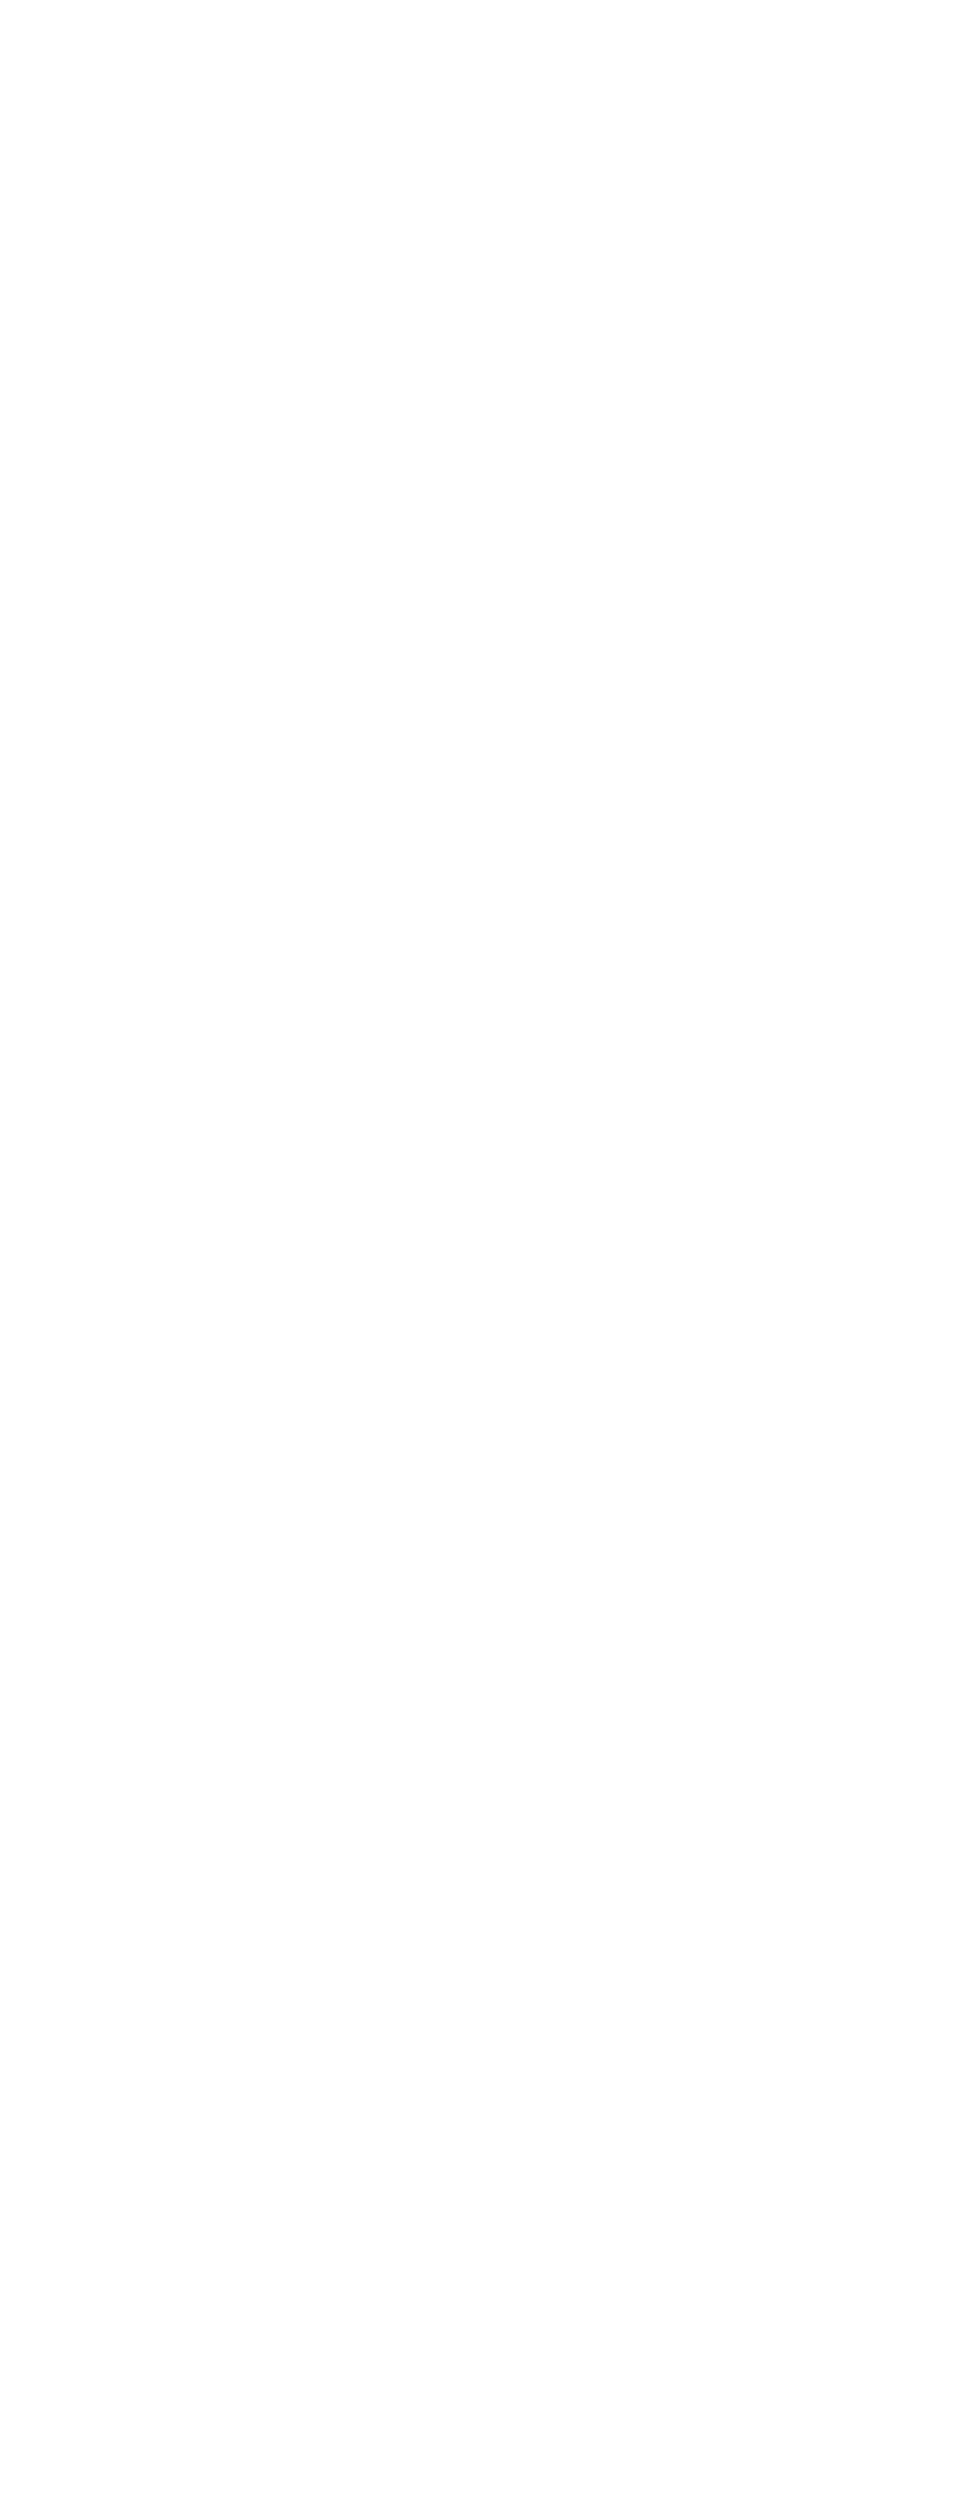

In [3]:
ncols = 3 # number of columns in final grid of images
nrows = 8 # looking at all images takes some time
_, axes = plt.subplots(nrows, ncols, figsize=(17, 17*nrows/ncols))
for axis in axes.flatten():
    axis.set_axis_off()
    axis.set_aspect('equal')

for k in range(0, nrows):
    im_test_original = Xte[k].reshape(*input_image_shape)
    im_result = imgs_mask_test[k].reshape(*input_image_shape)
    im_ground_truth = yte[k].reshape(*input_image_shape)
    
    axes[k, 0].set_title("Original Test Image")
    axes[k, 0].imshow(im_test_original, cmap='gray')
    
    axes[k, 1].set_title("Ground Truth")
    axes[k, 1].imshow(im_ground_truth, cmap='gray')
    
    axes[k, 2].set_title("Predicted")
    axes[k, 2].imshow(im_result, cmap='gray')

### Compare images quality

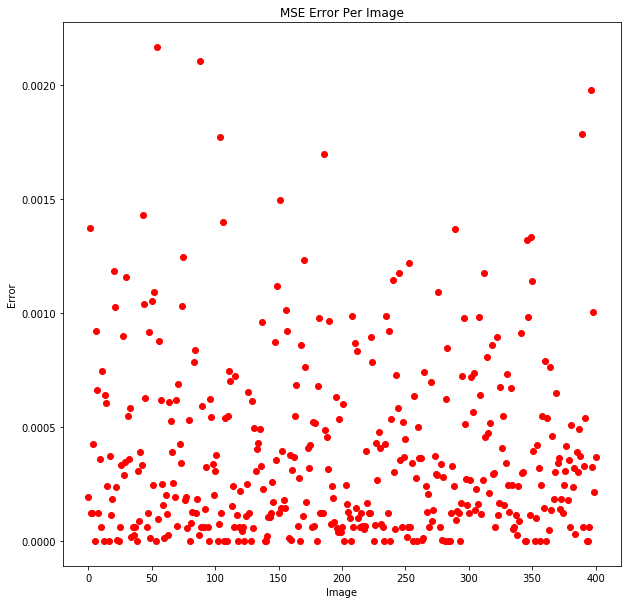

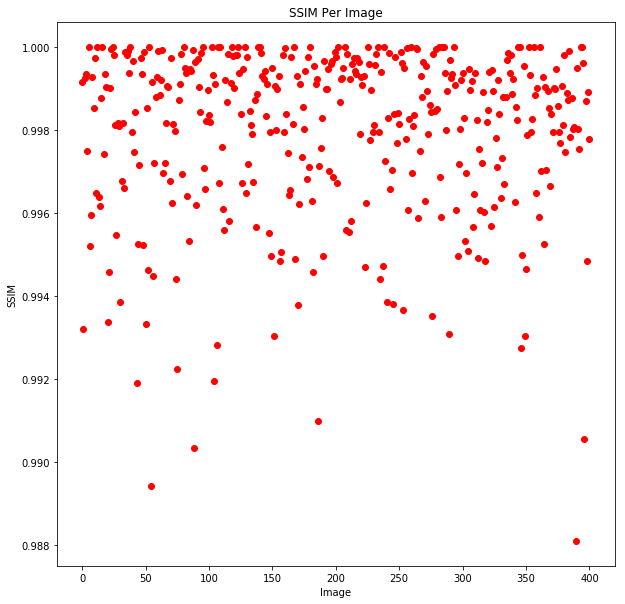

In [12]:
def mse(ground_truth, predicted):
    _, width, height, _ = ground_truth.shape
    return np.sum(( (predicted - ground_truth) ** 2), axis=(1,2,3)) / (width * height)

result = mse(imgs_mask_test, yte)

objects = tuple([x for x in range(yte.shape[0])])
y_pos = np.arange(len(objects))
 
plt.figure(figsize=(10, 10))
plt.plot(y_pos, result, 'ro')
#plt.bar(y_pos, result)
plt.ylabel('Error')
plt.xlabel('Image')
plt.title('MSE Error Per Image')
 
plt.show()

number_of_images, width, height, _ = yte.shape
objects = []
result = []
for i in range(number_of_images):
    objects.append(i)
    ground_truth = yte[i].astype('float32').reshape(yte.shape[1:3])
    predicted = imgs_mask_test[i].reshape(imgs_mask_test.shape[1:3])
    result.append(ssim(ground_truth, predicted))
    
objects = tuple(objects)
y_pos = np.arange(len(objects))
 
plt.figure(figsize=(10, 10))
plt.plot(y_pos, result, 'ro')
#plt.bar(y_pos, result)
plt.ylabel('SSIM')
plt.xlabel('Image')
plt.title('SSIM Per Image')
 
plt.show()

### Compare image quality results of all tests

In [13]:
def _setup_regularizers(conv_layer, use_regularizers):
    return BatchNormalization()(conv_layer) if use_regularizers else conv_layer
    
def _setup_dropout(conv_layer, use_dropout):
    return Dropout(dropout_rate)(conv_layer) if use_dropout else conv_layer

def get_model(kernel_size, use_regularizer, use_dropout, initial_volume_size):
    # Define model
    inputs = Input((*input_image_shape, 1))
    conv1 = Conv2D(initial_volume_size, kernel_size, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(initial_volume_size, kernel_size, activation='relu', padding='same')(conv1)
    conv1 = _setup_regularizers(conv1, use_regularizer)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(initial_volume_size*2, kernel_size, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(initial_volume_size*2, kernel_size, activation='relu', padding='same')(conv2)
    conv2 = _setup_regularizers(conv2, use_regularizer)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(initial_volume_size*4, kernel_size, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(initial_volume_size*4, kernel_size, activation='relu', padding='same')(conv3)
    conv3 = _setup_regularizers(conv3, use_regularizer)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(initial_volume_size*8, kernel_size, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(initial_volume_size*8, kernel_size, activation='relu', padding='same')(conv4)
    conv4 = _setup_regularizers(conv4, use_regularizer)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(initial_volume_size*16, kernel_size, activation='relu', padding='same')(pool4)
    conv5 = Conv2D(initial_volume_size*16, kernel_size, activation='relu', padding='same')(conv5)
    conv5 = _setup_regularizers(conv5, use_regularizer)

    up6 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv4], axis=3)
    up6 = _setup_dropout(up6, use_dropout)
    conv6 = Conv2D(initial_volume_size*8, kernel_size, activation='relu', padding='same')(up6)
    conv6 = Conv2D(initial_volume_size*8, kernel_size, activation='relu', padding='same')(conv6)

    up7 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv3], axis=3)
    up7 = _setup_dropout(up7, use_dropout)
    conv7 = Conv2D(initial_volume_size*4, kernel_size, activation='relu', padding='same')(up7)
    conv7 = Conv2D(initial_volume_size*4, kernel_size, activation='relu', padding='same')(conv7)

    up8 = concatenate([UpSampling2D(size=(2, 2))(conv7), conv2], axis=3)
    up8 = _setup_dropout(up8, use_dropout)
    conv8 = Conv2D(initial_volume_size*2, kernel_size, activation='relu', padding='same')(up8)
    conv8 = Conv2D(initial_volume_size*2, kernel_size, activation='relu', padding='same')(conv8)

    up9 = concatenate([UpSampling2D(size=(2, 2))(conv8), conv1], axis=3)
    up9 = _setup_dropout(up9, use_dropout)
    conv9 = Conv2D(initial_volume_size, kernel_size, activation='relu', padding='same')(up9)
    conv9 = Conv2D(initial_volume_size, kernel_size, activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=[inputs], outputs=[conv10])

    model.compile(optimizer=Adam(lr=1e-5), loss=dice_coef_loss, metrics=[dice_coef_accur])
    return model
    

In [29]:
trained_models = [
    #("datasets/dataset-1/test-1.hdf5", get_model((3,3), False, False, 32)),
    ("datasets/dataset-1/test-2-996--0.9361-0.9361.hdf5", get_model((3,3), False, False, 32)),
    ("datasets/dataset-1/test-3-97-0.9321.hdf5", get_model((3,3), False, False, 32)),
    ("datasets/dataset-1/test-4-new-tentative-608-0.9414.hdf5", get_model((3,3), False, False, 32)),
    ("datasets/dataset-1/test-5-new-tentative-682-0.9783.hdf5", get_model((3,3), True, True, 32)),
    #("datasets/dataset-1/test-6-144-0.9554.hdf5", get_model((5,5), True, True, 64)),
    ("datasets/dataset-1/test-6-new-tentative-105-0.9527.hdf5", get_model((5,5), True, True, 64))
]

def dice_coef_numpy(y_true, y_pred):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = 2 * np.sum(y_true_f * y_pred_f) + smooth
    union = np.sum(y_true_f) + np.sum(y_pred_f) + smooth
    return np.mean(intersection / union)

def _get_predicitions_for_model(trained_model):
    weights, model = trained_model
    model.load_weights(weights)
    imgs_mask_test = model.predict(Xte, verbose=1)
    return imgs_mask_test

def get_box_data_for_each_model(comparison_function):
    data = []
    for model_prediction in models_predictions: 
        result = []
        for i in range(number_of_images):
            ground_truth = yte[i].astype('float32').reshape(yte.shape[1:3])
            predicted = model_prediction[i].reshape(imgs_mask_test.shape[1:3])
            measure = comparison_function(ground_truth, predicted)
            result.append(measure)
        data.append(result)
    return data

def _create_box_plot(data, fig_identifier, subplot_index):
    # Create a figure instance
    fig = plt.figure(fig_identifier, figsize=(18, 12))

    # Create an axes instance
    ax = fig.add_subplot(subplot_index)

    # Create the boxplot
    bp = ax.boxplot(data, patch_artist=True)

    for box in bp['boxes']:
        # change outline color
        box.set( color='#000000', linewidth=2)
        # change fill color
        box.set( facecolor = 'pink' )

    ## change color and linewidth of the whiskers
    for whisker in bp['whiskers']:
        whisker.set(color='#000000', linewidth=2)

    ## change color and linewidth of the caps
    for cap in bp['caps']:
        cap.set(color='#000000', linewidth=2)

    ## change color and linewidth of the medians
    for median in bp['medians']:
        median.set(color='#ff0000', linewidth=2)

    ## change the style of fliers and their fill
    for flier in bp['fliers']:
        flier.set(marker='o', color='green')


models_predictions = []
for trained_model in trained_models:
    models_predictions.append(_get_predicitions_for_model(trained_model))

401/401 [==============================] - 819s 2s/step


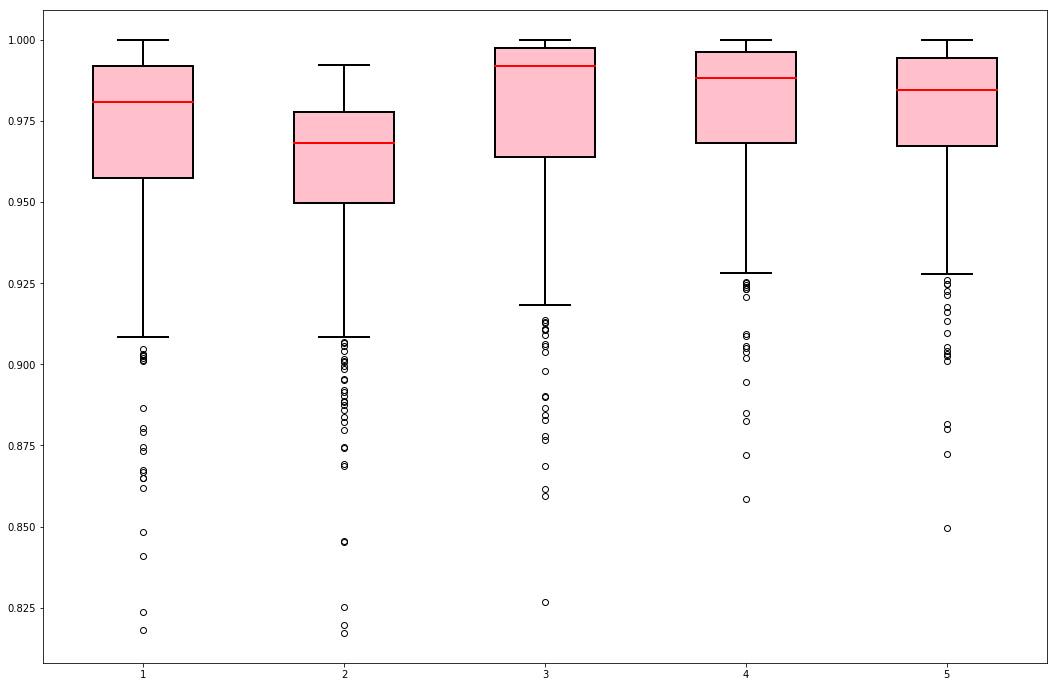

In [63]:
data = get_box_data_for_each_model(dice_coef_numpy)
_create_box_plot(data, 'dice', 111)

plt.show()

### Save predicted images to disk

In [ ]:
total_images, width, height, _ = imgs_mask_test.shape

for i in range(total_images):
    I = imgs_mask_test[i].reshape(width, height)
    I8 = (((I - I.min()) / (I.max() - I.min())) * 255.9).astype(np.uint8)
    img = Image.fromarray(I8)
    img.save(result_imgs_folder.format(i, 'predicted'))
    
    I = yte[i].reshape(width, height)
    I8 = (((I - I.min()) / (I.max() - I.min())) * 255.9).astype(np.uint8)
    img = Image.fromarray(I8)
    img.save(result_imgs_folder.format(i, 'gt'))

### Segmenting isolated image

['e8b196f5268ae6dc7f6915cbb48c88_big_gallery.jpeg', '7.gif', 'brain-mri.jpg', 'mri-aera-neurology-00042957_10.jpg', 'services-procedure-mri.png', '1.jpg', '2.jpg', '57b8c9597eca6af263751452cac585_big_gallery.jpeg', '8ad53e454a5a04f3ceab61820cbff7_gallery.jpg', '225598357_2f9c1268d7.jpg', 'brain-scan-611x600.jpg', '006T1MRI.jpg', 'MRI_brain.jpg', 'scan.jpg']
datasets/dataset-1/tests-random-images/8ad53e454a5a04f3ceab61820cbff7_gallery.jpg
datasets/dataset-1/tests-random-images/225598357_2f9c1268d7.jpg
datasets/dataset-1/tests-random-images/brain-scan-611x600.jpg
datasets/dataset-1/tests-random-images/006T1MRI.jpg
datasets/dataset-1/tests-random-images/MRI_brain.jpg
datasets/dataset-1/tests-random-images/scan.jpg
6/6 [==============================] - 11s 2s/step


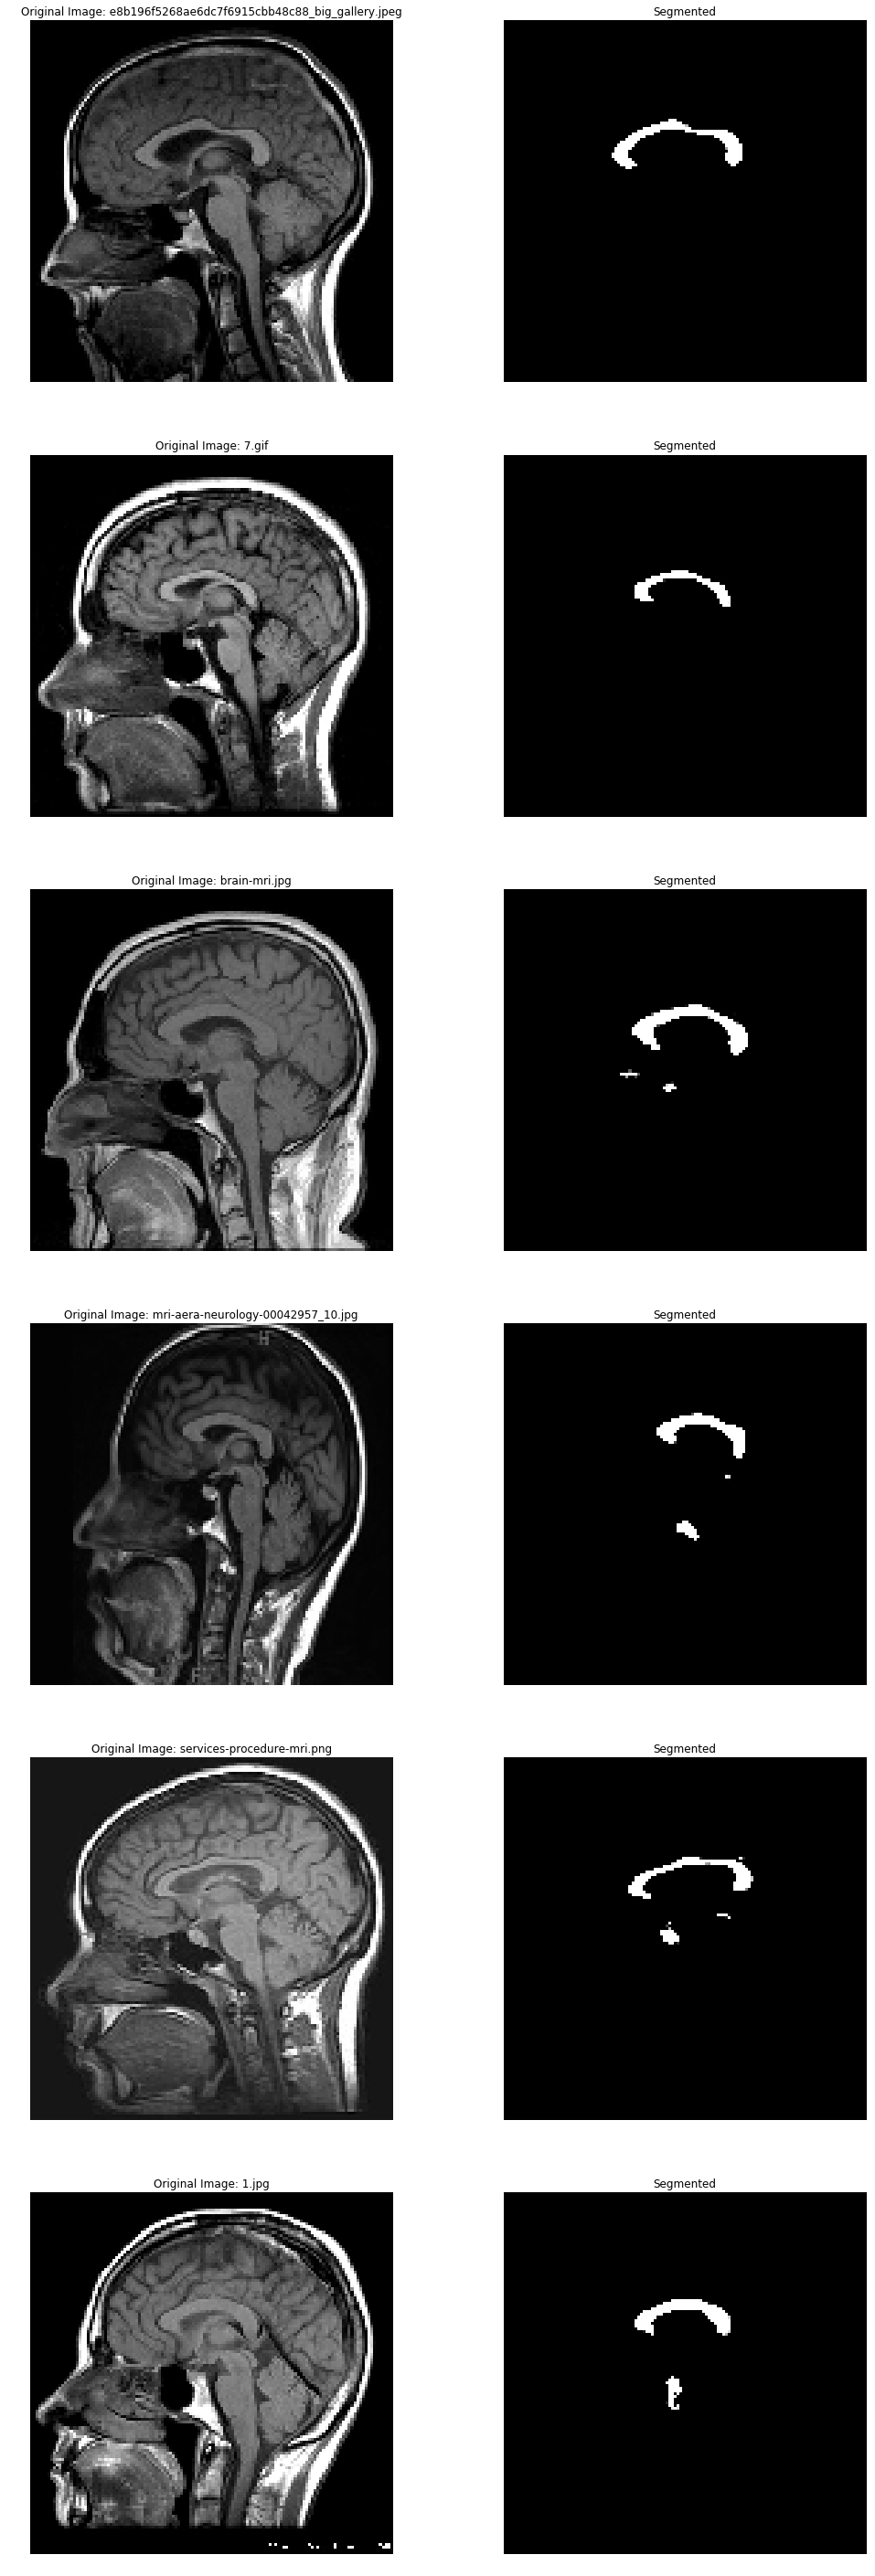

In [71]:
path = "datasets/dataset-1/tests-random-images"
images_in_disk = os.listdir(path)
print(images_in_disk)
img_size = (128, 128)
images = np.array([])
number_of_images_total = 0

for f in images_in_disk[8:]:
    input_image_location = os.path.join(path,f)
    if os.path.isfile(input_image_location):
        print(input_image_location)
        input_image = Image.open(input_image_location, 'r').convert('L').resize(img_size)
        input_image_array = np.array(input_image)

        images = np.append(images, input_image_array)
        number_of_images_total += 1

images = images.reshape(number_of_images_total, *img_size, 1)
images = (images - full_image_mean_value) / full_image_sd

segmented_images = model.predict(images, verbose=1)

ncols = 2 # number of columns in final grid of images
nrows = number_of_images_total # looking at all images takes some time
_, axes = plt.subplots(nrows, ncols, figsize=(17, 17*nrows/ncols))
for axis in axes.flatten():
    axis.set_axis_off()
    axis.set_aspect('equal')

for k in range(0, nrows):
    im_original = images[k].reshape(*img_size)
    im_result = segmented_images[k].reshape(*img_size)
    
    axes[k, 0].set_title("Original Image: {}".format(images_in_disk[k]))
    axes[k, 0].imshow(im_original, cmap='gray')
    
    axes[k, 1].set_title("Segmented")
    axes[k, 1].imshow(im_result, cmap='gray')

['e8b196f5268ae6dc7f6915cbb48c88_big_gallery.jpeg', '7.gif', 'brain-mri.jpg', 'mri-aera-neurology-00042957_10.jpg', 'services-procedure-mri.png', '1.jpg', '2.jpg', '57b8c9597eca6af263751452cac585_big_gallery.jpeg', '8ad53e454a5a04f3ceab61820cbff7_gallery.jpg', '225598357_2f9c1268d7.jpg', 'brain-scan-611x600.jpg', '006T1MRI.jpg', 'MRI_brain.jpg', 'scan.jpg']
datasets/dataset-1/tests-random-images/e8b196f5268ae6dc7f6915cbb48c88_big_gallery.jpeg
datasets/dataset-1/tests-random-images/7.gif
datasets/dataset-1/tests-random-images/brain-mri.jpg
datasets/dataset-1/tests-random-images/mri-aera-neurology-00042957_10.jpg
datasets/dataset-1/tests-random-images/services-procedure-mri.png
datasets/dataset-1/tests-random-images/1.jpg
datasets/dataset-1/tests-random-images/2.jpg
datasets/dataset-1/tests-random-images/57b8c9597eca6af263751452cac585_big_gallery.jpeg
datasets/dataset-1/tests-random-images/8ad53e454a5a04f3ceab61820cbff7_gallery.jpg
datasets/dataset-1/tests-random-images/225598357_2f9c126

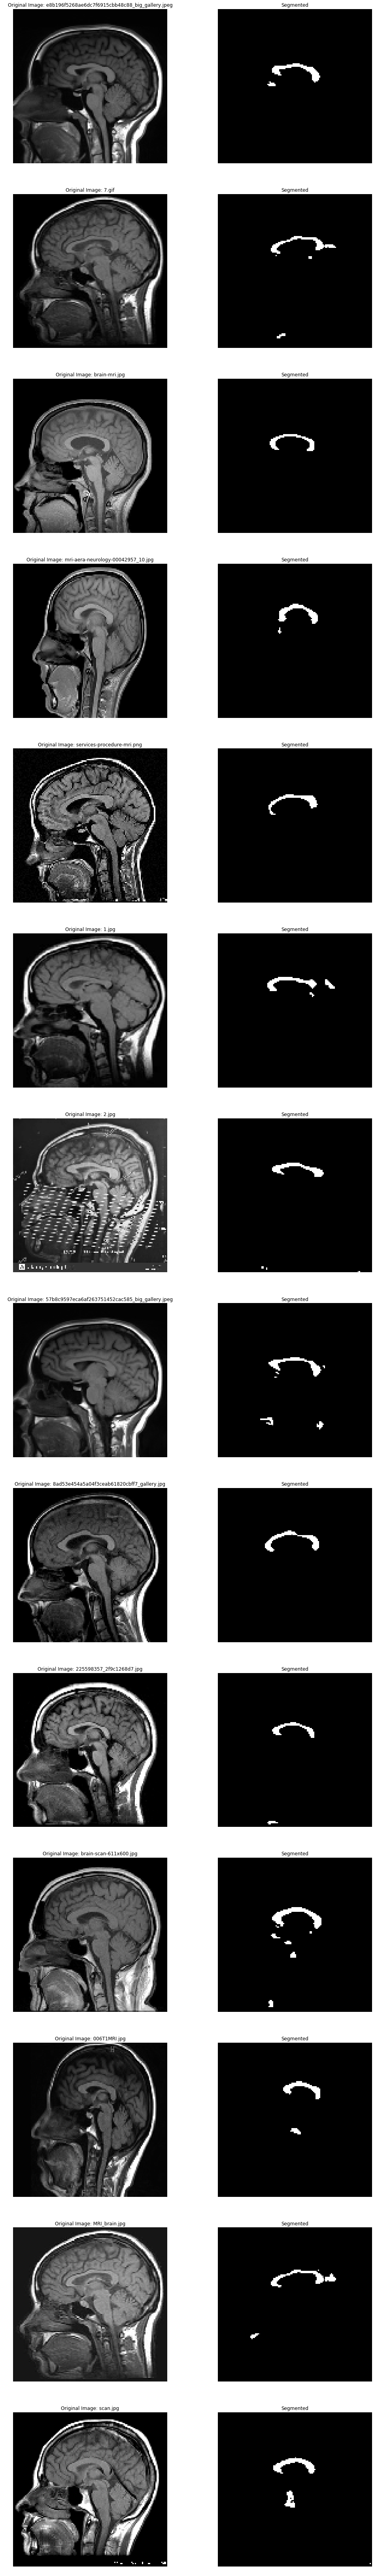

In [61]:
path = "datasets/dataset-1/tests-random-images"
images_in_disk = os.listdir(path)
print(images_in_disk)
img_size = (128, 128)
images = np.array([])
number_of_images_total = 0

for f in images_in_disk:
    input_image_location = os.path.join(path,f)
    if os.path.isfile(input_image_location):
        print(input_image_location)
        input_image = Image.open(input_image_location, 'r').convert('L').resize(img_size)
        input_image_array = np.array(input_image)

        images = np.append(images, input_image_array)
        number_of_images_total += 1

images = images.reshape(number_of_images_total, *img_size, 1)
images = (images - full_image_mean_value) / full_image_sd

segmented_images = model.predict(images, verbose=1)

ncols = 2 # number of columns in final grid of images
nrows = number_of_images_total # looking at all images takes some time
_, axes = plt.subplots(nrows, ncols, figsize=(17, 17*nrows/ncols))
for axis in axes.flatten():
    axis.set_axis_off()
    axis.set_aspect('equal')

for k in range(0, nrows):
    im_original = images[k].reshape(*img_size)
    im_result = segmented_images[k].reshape(*img_size)
    
    axes[k, 0].set_title("Original Image: {}".format(images_in_disk[k]))
    axes[k, 0].imshow(im_original, cmap='gray')
    
    axes[k, 1].set_title("Segmented")
    axes[k, 1].imshow(im_result, cmap='gray')

### Fun Experiment: Looking at the layers!

['input_2', 'conv2d_20', 'conv2d_21', 'batch_normalization_6', 'max_pooling2d_5', 'conv2d_22', 'conv2d_23', 'batch_normalization_7', 'max_pooling2d_6', 'conv2d_24', 'conv2d_25', 'batch_normalization_8', 'max_pooling2d_7', 'conv2d_26', 'conv2d_27', 'batch_normalization_9', 'max_pooling2d_8', 'conv2d_28', 'conv2d_29', 'batch_normalization_10', 'up_sampling2d_5', 'concatenate_5', 'dropout_5', 'conv2d_30', 'conv2d_31', 'up_sampling2d_6', 'concatenate_6', 'dropout_6', 'conv2d_32', 'conv2d_33', 'up_sampling2d_7', 'concatenate_7', 'dropout_7', 'conv2d_34', 'conv2d_35', 'up_sampling2d_8', 'concatenate_8', 'dropout_8', 'conv2d_36', 'conv2d_37', 'conv2d_38']


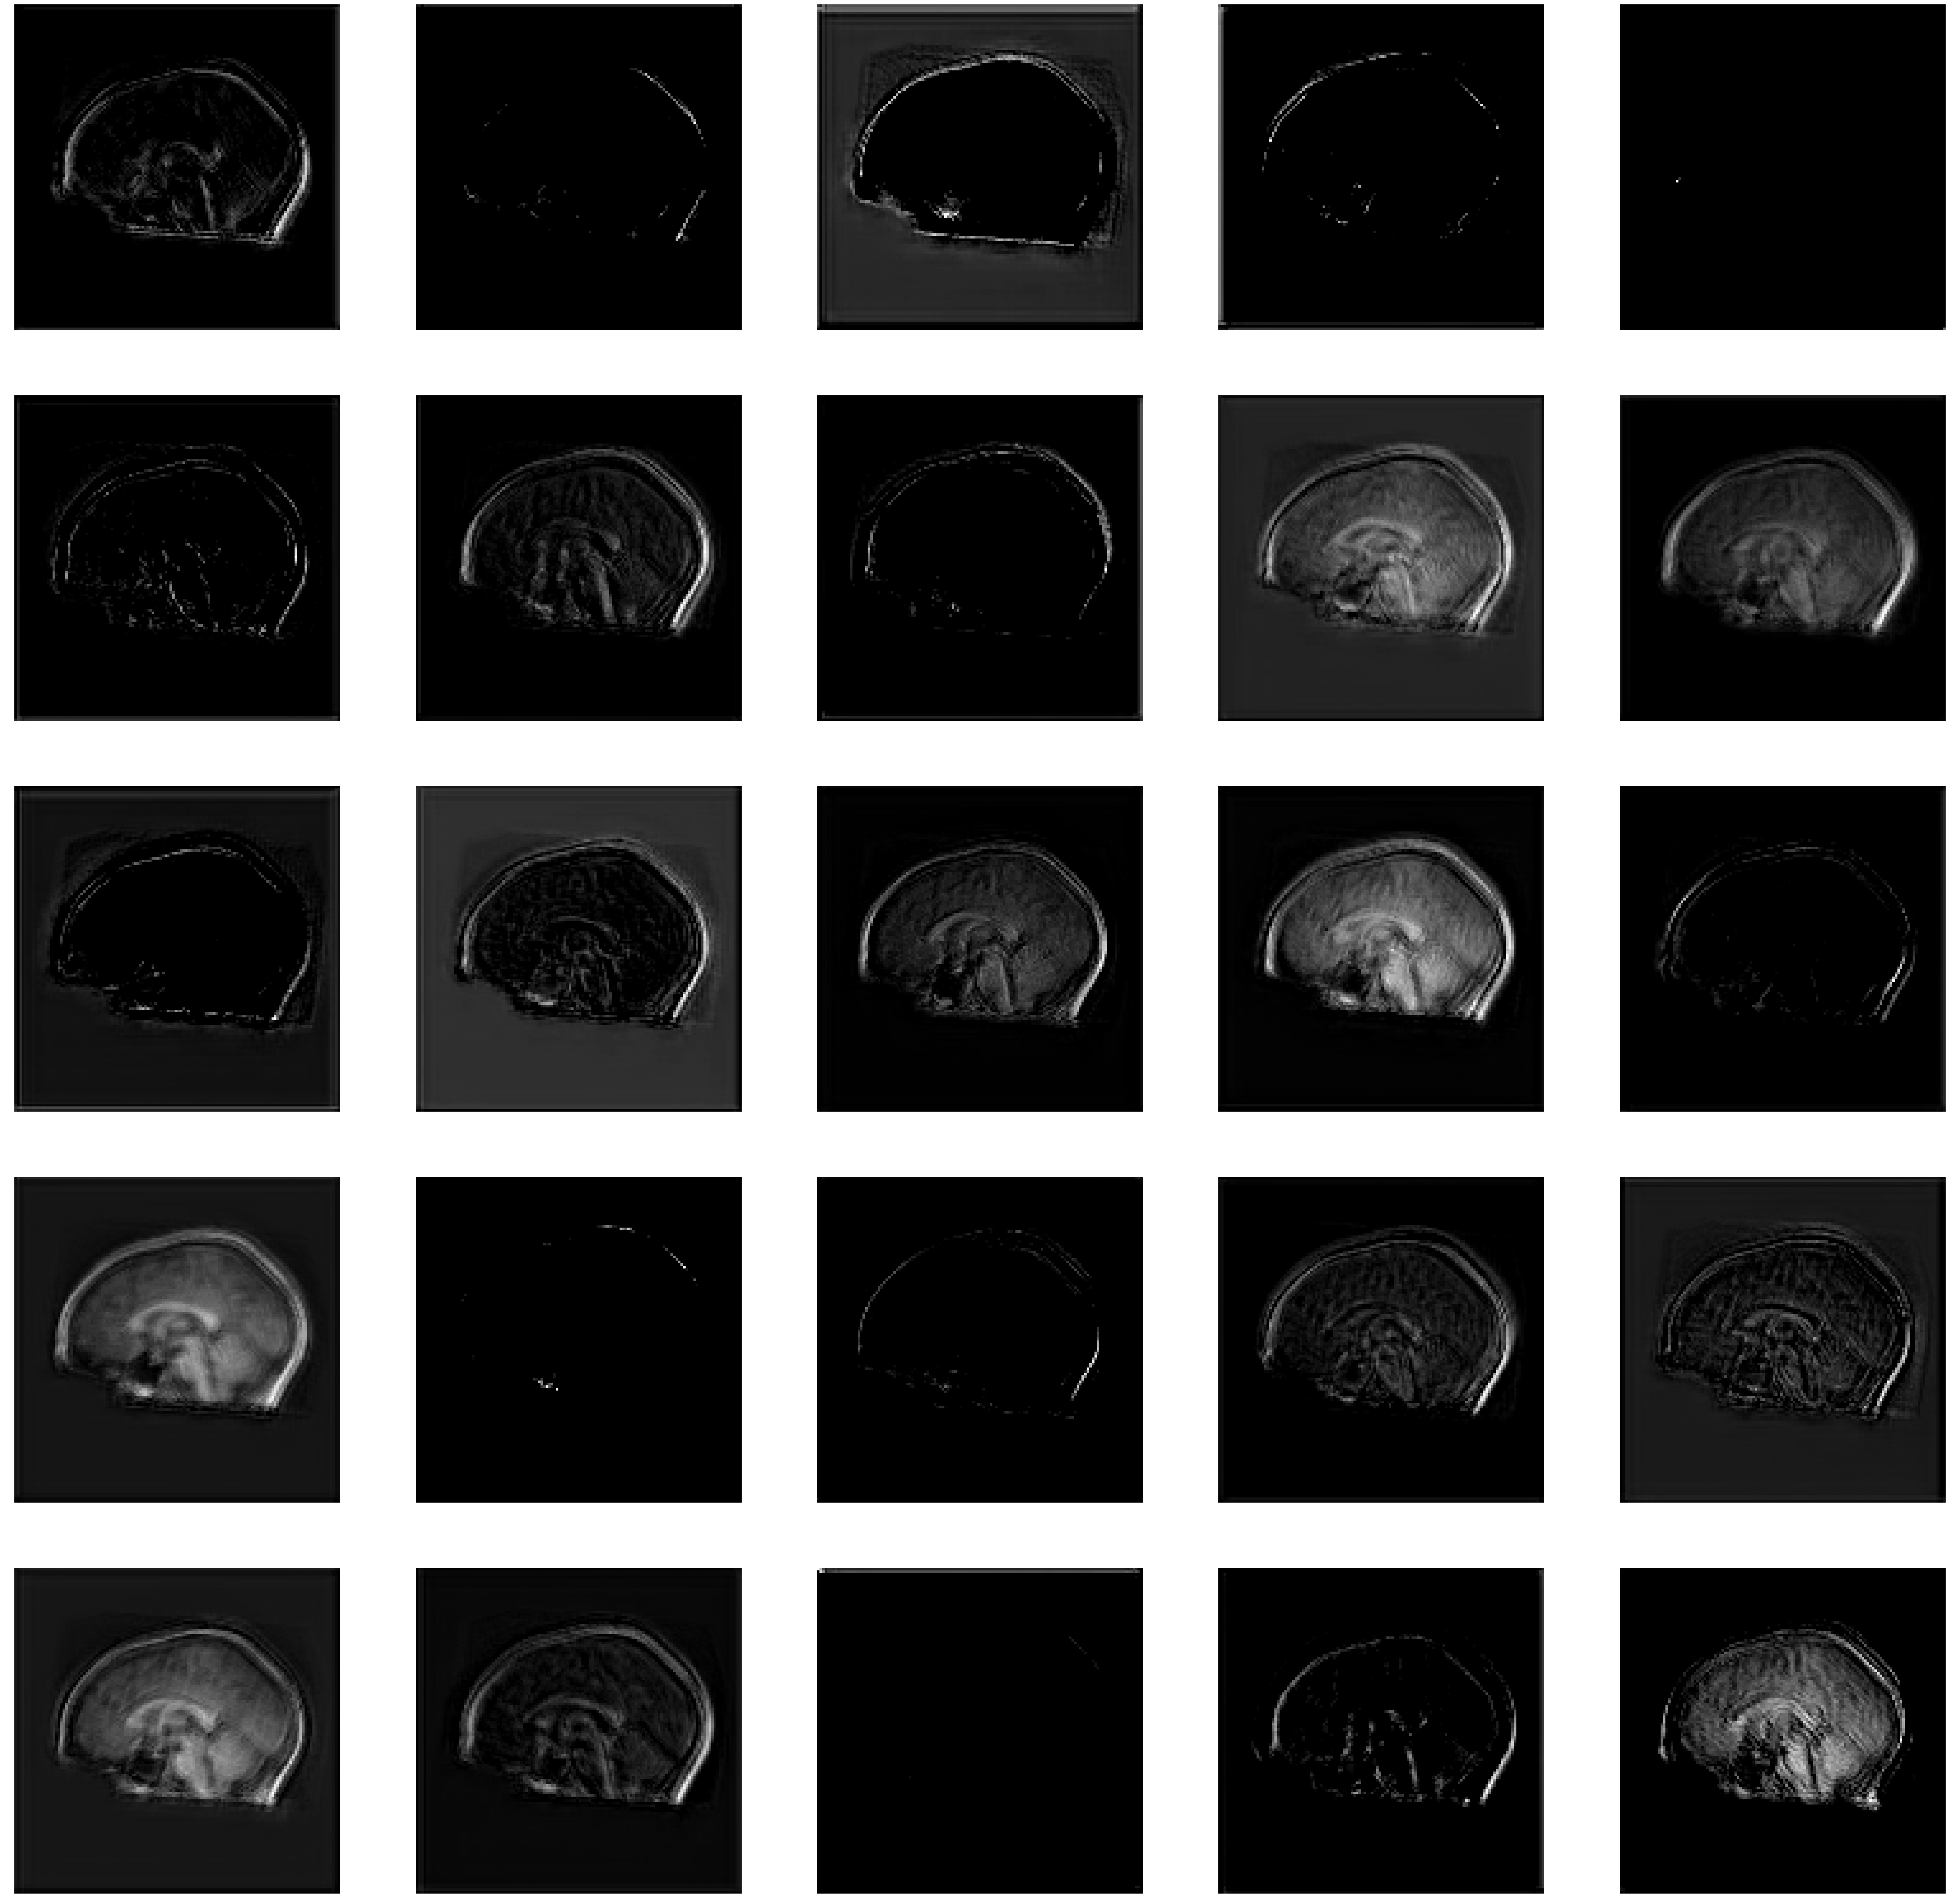

In [48]:
def _get_convolutions(layer_name):
    output = [layer.output for layer in model.layers if
               layer.name == layer_name or layer_name is None][0]
    inputs = [K.learning_phase()] + model.inputs
    _convout1_f = K.function(inputs, [output])
    def convout1_f(X):
        # The [0] is to disable the training phase flag
        return _convout1_f([0] + [X])
    
    convolutions = convout1_f(Xte[0:1])
    convolutions = np.squeeze(convolutions)
    return convolutions


def layer_to_visualize(layer_name, save_plot=False):
    convolutions = _get_convolutions(layer_name)
    #print ('Shape of conv:', convolutions.shape)

    n = convolutions.shape[0]
    
    from math import sqrt
    ncols = nrows = int(sqrt(convolutions.shape[2])) # board
    fig, axes = plt.subplots(nrows, ncols, figsize=(80, 80*nrows/ncols))
    for axis in axes.flatten():
        axis.set_axis_off()
        axis.set_aspect('equal')
    
    for k in range(0, nrows):
        for j in range(0, ncols):
            axes[k, j].imshow(convolutions[:,:,k*nrows+j], cmap='gray')
    if save_plot:
        fig.savefig(layer_name)


"""layers_name = ['conv2d_136', 'conv2d_137', 'batch_normalization_17', 'max_pooling2d_29', 
               'conv2d_138', 'conv2d_139', 'batch_normalization_18', 'max_pooling2d_30', 'conv2d_140', 
               'conv2d_141', 'batch_normalization_19', 'max_pooling2d_31', 'conv2d_142', 'conv2d_143', 
               'batch_normalization_20', 'max_pooling2d_32', 'conv2d_144', 'conv2d_145', 
               'batch_normalization_21', 'up_sampling2d_29', 'concatenate_29', 'dropout_13', 'conv2d_146', 
               'conv2d_147', 'up_sampling2d_30', 'concatenate_30', 'dropout_14', 'conv2d_148', 'conv2d_149', 
               'up_sampling2d_31', 'concatenate_31', 'dropout_15', 'conv2d_150', 'conv2d_151', 'up_sampling2d_32', 
               'concatenate_32', 'dropout_16', 'conv2d_152', 'conv2d_153', 'conv2d_154']"""

layers_name = [layer.name for layer in model.layers]
print(layers_name)

#for layer in layers_name:
    # Specify the layer to want to visualize
layer_to_visualize(layer_name='conv2d_37', save_plot=False)

#a = get_activations(model, imgs_mask_test[0:1], print_shape_only=True)  # with just one sample.
#display_activations(a)

### Fun Experiment 2: Looking at Layers using PCA

(128, 128, 32)


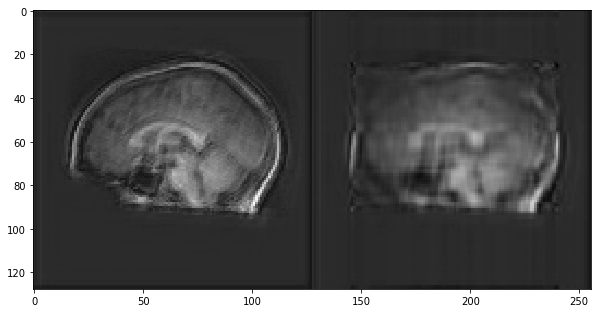

In [102]:
def side_by_side(indexes):
    org = Xtr[indexes].reshape(28,28)
    rec = inv_sc[indexes].reshape(28,28)
    pair = np.concatenate((org, rec), axis=1)
    plt.figure(figsize=(4,2))
    plt.imshow(pair)
    plt.show()
    
#for index in range(0,10):
    #side_by_side(index)

convs = _get_convolutions(layer_name='conv2d_37')
print(convs.shape)
    
pca = PCA(n_components=7)
test = convs[:,:,20]
pca_result = pca.fit_transform(test)

inv_pca = pca.inverse_transform(pca_result)

pair = np.concatenate((test, inv_pca), axis=1)
plt.figure(figsize=(10,10))
plt.imshow(pair, cmap='gray')
plt.show()

